#### Класс для генерации исходного изображения и маски

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline


class BaseDataProvider(object):
    channels = 1
    n_class = 2

    def __init__(self, a_min=None, a_max=None):
        self.a_min = a_min if a_min is not None else -np.inf
        self.a_max = a_max if a_min is not None else np.inf

    def _load_data_and_label(self):
        data, label = self._next_data()

        train_data = self._process_data(data)
        labels = self._process_labels(label)

        train_data, labels = self._post_process(train_data, labels)

        nx = train_data.shape[1]
        ny = train_data.shape[0]

        return train_data.reshape(1, ny, nx, self.channels), labels.reshape(1, ny, nx, self.n_class),

    def _process_labels(self, label):
        if self.n_class == 2:
            nx = label.shape[1]
            ny = label.shape[0]
            labels = np.zeros((ny, nx, self.n_class), dtype=np.float32)

            # It is the responsibility of the child class to make sure that the label
            # is a boolean array, but we a chech here just in case.
            if label.dtype != 'bool':
                label = label.astype(np.bool_)

            labels[..., 1] = label
            labels[..., 0] = ~label
            return labels

        return label

    def _process_data(self, data):
        # normalization
        data = np.clip(np.fabs(data), self.a_min, self.a_max)
        data -= np.amin(data)

        if np.amax(data) != 0:
            data /= np.amax(data)

        return data

    def _post_process(self, data, labels):
        """
        Post processing hook that can be used for data augmentation
        :param data: the data array
        :param labels: the label array
        """
        return data, labels

    def __call__(self, n):
        train_data, labels = self._load_data_and_label()
        nx = train_data.shape[1]
        ny = train_data.shape[2]

        X = np.zeros((n, nx, ny, self.channels))
        Y = np.zeros((n, nx, ny, self.n_class))

        X[0] = train_data
        Y[0] = labels
        for i in range(1, n):
            train_data, labels = self._load_data_and_label()
            X[i] = train_data
            Y[i] = labels

        return X, Y

class GrayScaleDataProvider(BaseDataProvider):
    channels = 1
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(GrayScaleDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3

    def _next_data(self):
        return create_image_and_label(self.nx, self.ny, **self.kwargs)

class RgbDataProvider(BaseDataProvider):
    channels = 3
    n_class = 2

    def __init__(self, nx, ny, **kwargs):
        super(RgbDataProvider, self).__init__()
        self.nx = nx
        self.ny = ny
        self.kwargs = kwargs
        rect = kwargs.get("rectangles", False)
        if rect:
            self.n_class=3


    def _next_data(self):
        data, label = create_image_and_label(self.nx, self.ny, **self.kwargs)
        return to_rgb(data), label

def create_image_and_label(nx,ny, cnt = 10, r_min = 5, r_max = 50, border = 92, sigma = 20, rectangles=False):


    image = np.ones((nx, ny, 1))
    label = np.zeros((nx, ny, 3), dtype=np.bool_)
    mask = np.zeros((nx, ny), dtype=np.bool_)
    for _ in range(cnt):
        a = np.random.randint(border, nx-border)
        b = np.random.randint(border, ny-border)
        r = np.random.randint(r_min, r_max)
        h = np.random.randint(1,255)

        y,x = np.ogrid[-a:nx-a, -b:ny-b]
        m = x*x + y*y <= r*r
        mask = np.logical_or(mask, m)

        image[m] = h

    label[mask, 1] = 1

    if rectangles:
        mask = np.zeros((nx, ny), dtype=np.bool_)
        for _ in range(cnt//2):
            a = np.random.randint(nx)
            b = np.random.randint(ny)
            r =  np.random.randint(r_min, r_max)
            h = np.random.randint(1,255)

            m = np.zeros((nx, ny), dtype=np.bool_)
            m[a:a+r, b:b+r] = True
            mask = np.logical_or(mask, m)
            image[m] = h

        label[mask, 2] = 1

        label[..., 0] = ~(np.logical_or(label[...,1], label[...,2]))

    image += np.random.normal(scale=sigma, size=image.shape)
    image -= np.amin(image)
    image /= np.amax(image)

    if rectangles:
        return image, label
    else:
        return image, label[..., 1]




def to_rgb(img):
    img = img.reshape(img.shape[0], img.shape[1])
    img[np.isnan(img)] = 0
    img -= np.amin(img)
    img /= np.amax(img)
    blue = np.clip(4*(0.75-img), 0, 1)
    red  = np.clip(4*(img-0.25), 0, 1)
    green= np.clip(44*np.fabs(img-0.5)-1., 0, 1)
    rgb = np.stack((red, green, blue), axis=2)
    return rgb


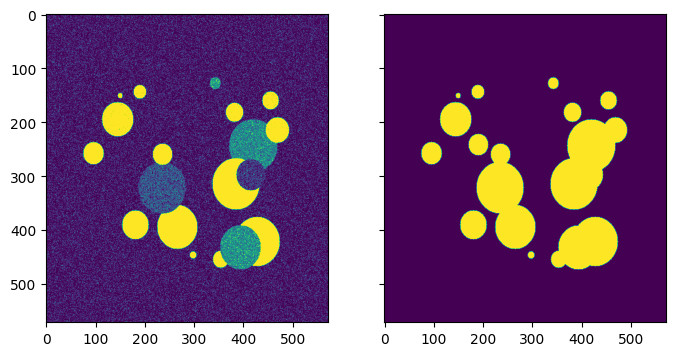

In [2]:
nx = 572
ny = 572

generator = RgbDataProvider(nx, ny, cnt=20)

x_test, y_test = generator(1)

fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")

#### Импортируем необходимые библиотеки

In [3]:
# ! pip install torch_snippets

import torch.cuda
from torch_snippets import *
from torchvision import transforms
import torch.nn as nn
from sklearn.model_selection import train_test_split
import os
from torch.utils.data import Dataset, DataLoader, TensorDataset
from pathlib import Path
import cv2

import warnings
warnings.filterwarnings("ignore")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

#### Определим класс для датасета и даталоудера

In [4]:
# Определим функцию которая будет отвечать за трансформацию и аугментацию (пока нормализацию) датасета
transforms_imgs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Теперь нам необходимо определить и расписать класс датасета, который мы будем использовать для того, чтобы решить задачу сегментации

class SegData(Dataset):
    def __init__(self, size):
        self.items, self.masks = generator(size)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, ix):
        """
        В данном методе мы будем ресайзить как картинку (наш инпут) так и маску (аутпут) для того
        чтобы они имели одинаковую размерность и наша архитектура была способно обработать 2 изображения
        одновременно без ошибок.
        Маска содержит целочисленные значения которые лежат в промежутке от 0 до 11 (то есть у нас всего 12 потенциальных классов
        в размеченной маске).
        """
        image = self.items[ix]
        image = cv2.resize(image, (224, 224))
        mask = self.masks[ix][..., 1]
        mask = cv2.resize(mask, (224, 224))
        return image, mask

    def choose(self):
        return self[randint(len(self))]

    def collate_fn(self, batch):
        """
        Метод который обрабатывает наш батч (читает маску и картинку, преваращет в тензор, нормализирует изображение (не маску!!!!) и отправляет на указанный девайс.
        """
        ims, masks = list(zip(*batch))
        ims = torch.cat([transforms_imgs(im.copy()/255.)[None] for im in ims]).float().to(device)
        ce_masks = torch.cat([torch.Tensor(mask[None]) for mask in masks]).long().to(device)
        return ims, ce_masks

# Определяем тестовый и тренировочный датасеты и аналогично даталоудеры:
trn_ds = SegData(4)
val_ds = SegData(1)
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True, collate_fn=trn_ds.collate_fn)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True, collate_fn=val_ds.collate_fn)

#### Класс для архитектуры U-Net

In [5]:
# сверточный блок для левой части архитектуры

def convolve(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace = True)
    )

# апсемплинг блок для правой части архитектуры

def up_convolve(in_channels, out_channels):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size = 2, stride = 2),
        nn.ReLU(inplace = True)
    )

# Теперь определим всю архитектуру для U-Net:
from torchvision.models import vgg16_bn

class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=2):
        super().__init__()
        # Будем использовать модель VGG-16 в качестве энкодера
        self.encoder = vgg16_bn(pretrained=pretrained).features
        # Разделим VGG поблочно на отдельные блоки чтобы было удобно их модифицировать и обращаться к ним
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        # Боттлнек нашей архитектуры (самый глубокий уровень сети -> смотри архитектуру U-Net на картинке выше)
        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = convolve(512, 1024)

        # Блоки декодера с "транспонированными свертками" и сверточными блоками
        self.up_conv6 = up_convolve(1024, 512)
        self.conv6 = convolve(512 + 512, 512)
        self.up_conv7 = up_convolve(512, 256)
        self.conv7 = convolve(256 + 512, 256)
        self.up_conv8 = up_convolve(256, 128)
        self.conv8 = convolve(128 + 256, 128)
        self.up_conv9 = up_convolve(128, 64)
        self.conv9 = convolve(64 + 128, 64)
        self.up_conv10 = up_convolve(64, 32)
        self.conv10 = convolve(32 + 64, 32)
        # Финальный сверточный слой для приведения к нужному числу каналов
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        # Проход через блоки энкодера
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        # Проход через блок боттлнека
        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        # Проход через блоки декодера с использованием "skip connections"
        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        # Проход через финальный свёрточный слой
        x = self.conv11(x)

        return x

#### Зададим функцию потерь и функции для тренировки на батче данных и расчет метрик для валидациии

In [6]:
ce = nn.CrossEntropyLoss()

def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

#### Определение параметров модели

In [7]:
model = UNet().to(device)
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 200

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth
100%|██████████| 528M/528M [00:08<00:00, 62.3MB/s]


#### Тренировка

EPOCH: 1.000  trn_acc: nan  val_loss: nan  val_acc: nan  trn_loss: nan  (7.40s - 1472.00s remaining)
EPOCH: 6.000  trn_acc: 0.966  val_loss: 0.631  val_acc: 0.864  trn_loss: 0.315  (8.20s - 264.99s remaining)
EPOCH: 11.000  trn_acc: 0.985  val_loss: 0.584  val_acc: 0.864  trn_loss: 0.248  (8.95s - 153.85s remaining)
EPOCH: 16.000  trn_acc: 0.991  val_loss: 0.521  val_acc: 0.864  trn_loss: 0.208  (9.71s - 111.70s remaining)
EPOCH: 21.000  trn_acc: 0.995  val_loss: 0.451  val_acc: 0.864  trn_loss: 0.182  (10.48s - 89.31s remaining)
EPOCH: 31.000  trn_acc: 0.996  val_loss: 0.328  val_acc: 0.901  trn_loss: 0.143  (12.00s - 65.43s remaining)
EPOCH: 41.000  trn_acc: 0.997  val_loss: 0.185  val_acc: 0.976  trn_loss: 0.113  (13.60s - 52.75s remaining)
EPOCH: 51.000  trn_acc: 0.998  val_loss: 0.130  val_acc: 0.990  trn_loss: 0.091  (15.20s - 44.40s remaining)
EPOCH: 61.000  trn_acc: 0.998  val_loss: 0.099  val_acc: 0.991  trn_loss: 0.075  (16.73s - 38.12s remaining)
EPOCH: 71.000  trn_acc: 0.99

100%|██████████| 301/301 [00:00<00:00, 7176.31it/s]


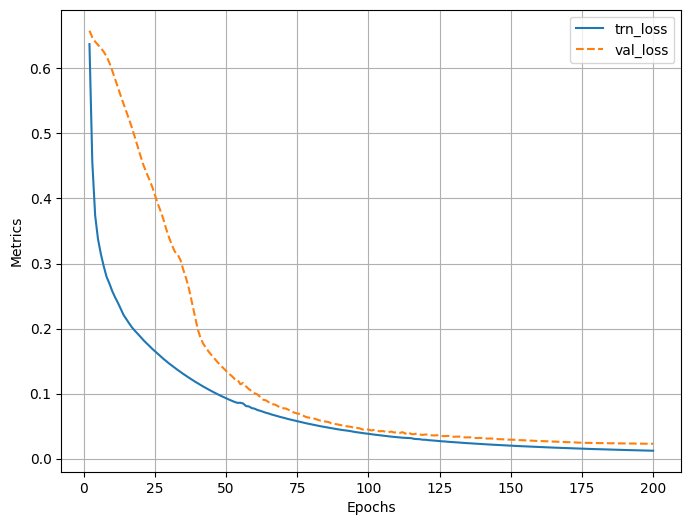

In [8]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer,criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss,trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss,val_acc=acc, end='\r')

    if ((ex % 5 == 0) and (ex < 20)) or (ex % 10 == 0):
      log.report_avgs(ex+1)

log.plot_epochs(['trn_loss','val_loss'])

#### Визуализация результата

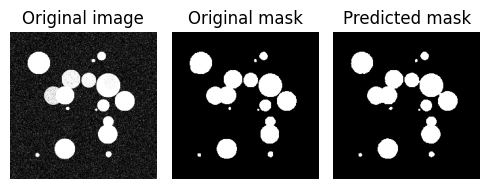

In [9]:
im, mask = next(iter(val_dl))
_mask = model(im)

# Заберем канал который имеет наивысшую вероятность
_, _mask = torch.max(_mask, dim=1)

subplots([im[0].permute(1,2,0).detach().cpu()[:,:,0], mask.permute(1,2,0).detach().cpu()[:,:,0], \
          _mask.permute(1,2,0).detach().cpu()[:,:,0]],nc=3,titles=['Original image','Original mask', \
          'Predicted mask'])